# Build a Custom Training Container and Debug Training Jobs with Amazon SageMaker Debugger

Amazon SageMaker Debugger enables you to debug your model through its built-in rules and tools (`smdebug` hook and core features) to store and retrieve output tensors in Amazon Simple Storage Service (S3). 
To run your customized machine learning/deep learning (ML/DL) models, use Amazon Elastic Container Registry (ECR) to build and push your customized training container. 
Use SageMaker Debugger for training jobs run on Amazon EC2 instance and take the benefit of its built-in functionalities.

You can bring your own model customized with state-of-the-art ML/DL frameworks, such as TensorFlow, PyTorch, MXNet, and XGBoost. 
You can also use your Docker base image or AWS Deep Learning Container base images to build a custom training container.
To run and debug your training script using SageMaker Debugger, you need to register the Debugger hook to the script.
Using the `smdebug` trial feature, you can retrieve the output tensors and visualize it for analysis.

By monitoring the output tensors, the Debugger rules detect training issues and invoke a `IssueFound` rule job status. 
The rule job status also returns at which step or epoch the training job started having the issues. 
You can send this invoked status to Amazon CloudWatch and AWS Lambda to stop the training job when the Debugger rule triggers the `IssueFound` status.

The workflow is as follows:

- [Step 1: Prepare prerequisites](#step1)
- [Step 2: Prepare a Dockerfile and register the Debugger hook to you training script](#step2)
- [Step 3: Create a Docker image, build the Docker training container, and push to Amazon ECR](#step3)
- [Step 4: Use Amazon SageMaker to set the Debugger hook and rule configuration](#step4)
- [Step 5: Define a SageMaker Estimator object with Debugger and initiate a training job](#step5)
- [Step 6: Retrieve output tensors using the smdebug trials class](#step6)
- [Step 7: Analyze the training job using the smdebug trial methods and rule job status](#step7)

**Important:** You can run this notebook only on SageMaker Notebook instances. You cannot run this in SageMaker Studio. Studio does not support Docker container build.

## Step 1: Prepare prerequisites<a class="anchor" id="step1"></a>

### Install the SageMaker Python SDK v2 and the smdebug library

This notebook runs on the latest version of the SageMaker Python SDK and the `smdebug` client library. If you want to use one of the previous version, specify the version number for installation. For example, `pip install sagemaker==x.xx.0`.

In [ ]:
import sys

!{sys.executable} -m pip install "sagemaker==1.72.0" smdebug

### [Optional Step] Restart the kernel to apply the update

**Note:** If you are using **Jupyter Notebook**, the previous cell automatically installs and updates the libraries. If you are using **JupyterLab**, you have to manually choose the "Restart Kernel" under the **Kernel** tab in the top menu bar.

Check the SageMaker Python SDK version by running the following cell.

In [ ]:
import sagemaker

sagemaker.__version__

## Step 2: Prepare a Dockerfile and register the Debugger hook to you training script<a class="anchor" id="step2"></a>

You need to put your **Dockerfile** and training script (**tf_keras_resnet_byoc.py** in this case) in the **docker** folder. Specify the location of the training script in the **Dockerfile** script in the line for `COPY` and `ENV`.

### Prepare a Dockerfile

The following cell prints the **Dockerfile** in the **docker** folder. You must install `sagemaker-training` and `smdebug` libraries to fully access the SageMaker Debugger features.

In [3]:
! pygmentize docker/Dockerfile

FROM tensorflow/tensorflow:2.2.0rc2-py3-jupyter

# Install Amazon SageMaker training toolkit and smdebug libraries
RUN pip install sagemaker-training
RUN pip install smdebug

# Copies the training code inside the container
COPY tf_keras_resnet_byoc.py /opt/ml/code/tf_keras_resnet_byoc.py

# Defines train.py as script entrypoint
ENV SAGEMAKER_PROGRAM tf_keras_resnet_byoc.py


### Prepare a training script

The following cell prints an example training script **tf_keras_resnet_byoc.py** in the **docker** folder. To register the Debugger hook, you need to use the Debugger client library `smdebug`. 

In the `main` function, a Keras hook is registered after the line where the `model` object is defined and before the line where the `model.compile()` function is called. 

In the `train` function, you pass the Keras hook and set it as a Keras callback for the `model.fit()` function. The `hook.save_scalar()` method is used to save scalar parameters for mini batch settings, such as epoch, batch size, and the number of steps per epoch in training and validation modes.

In [4]:
! pygmentize docker/tf_keras_resnet_byoc.py

"""
This script is a ResNet training script which uses Tensorflow's Keras interface, and provides an example of how to use SageMaker Debugger when you use your own custom container in SageMaker or your own script outside SageMaker.
It has been orchestrated with SageMaker Debugger hooks to allow saving tensors during training.
These hooks have been instrumented to read from a JSON configuration that SageMaker puts in the training container.
Configuration provided to the SageMaker python SDK when creating a job will be passed on to the hook.
This allows you to use the same script with different configurations across different runs.

If you use an official SageMaker Framework container (i.e. AWS Deep Learning Container), you do not have to orchestrate your script as below. Hooks are automatically added in those environments. This experience is called a "zero script change". For more information, see https://github.com/awslabs/sagemaker-debugger/blob/master/docs/sagemaker.md#zero-script-ch

## Step 3: Create a Docker image, build the Docker training container, and push to Amazon ECR<a class="anchor" id="step3"></a>

### Create a Docker image

AWS Boto3 Python SDK provides tools to automatically locate your region and account information to create a Docker image uri.

In [ ]:
import boto3

account_id = boto3.client("sts").get_caller_identity().get("Account")
ecr_repository = "sagemaker-debugger-mnist-byoc-tf2"
tag = ":latest"

region = boto3.session.Session().region_name

uri_suffix = "amazonaws.com"
if region in ["cn-north-1", "cn-northwest-1"]:
    uri_suffix = "amazonaws.com.cn"
byoc_image_uri = "{}.dkr.ecr.{}.{}/{}".format(account_id, region, uri_suffix, ecr_repository + tag)

Print the image URI address.

In [ ]:
byoc_image_uri

### [Optional Step] Login to access the Deep Learning Containers image repository

If you use one of the AWS Deep Learning Container base images, uncomment the following cell and execute to login to the image repository.

In [ ]:
# ! aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com

### Build the Docker container and push it to Amazon ECR

The following code cell builds a Docker container based on the Dockerfile, create an Amazon ECR repository, and push the container to the ECR repository.

In [ ]:
!docker build -t $ecr_repository docker
!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)
!aws ecr create-repository --repository-name $ecr_repository
!docker tag {ecr_repository + tag} $byoc_image_uri
!docker push $byoc_image_uri

**Note:** If this returns a permission error, see the [Get Started with Custom Training Containers](https://docs.aws.amazon.com/sagemaker/latest/dg/build-container-to-train-script-get-started.html#byoc-training-step5) in the Amazon SageMaker developer guide. Follow the note in Step 5 to register the **AmazonEC2ContainerRegistryFullAccess** policy to your IAM role.

## Step 4: Use Amazon SageMaker to set the Debugger hook and rule configuration<a class="anchor" id="step4"></a>

### Define Debugger hook configuration

Now you have the custom training container with the Debugger hooks registered to your training script. In this section, you import the SageMaker Debugger API operations, `Debugger hook Config` and `CollectionConfig`, to define the hook configuration. You can choose Debugger pre-configured tensor collections, adjust `save_interval` parameters, or configure custom collections.

In the following notebook cell, the `hook_config` object is configured with the pre-configured tensor collections, `losses`. This will save the tensor outputs to the default S3 bucket. At the end of this notebook, we will retrieve the `loss` values to plot the overfitting problem that the example training job will be experiencing.

In [ ]:
import sagemaker
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

sagemaker_session = sagemaker.Session()

train_save_interval = 100
eval_save_interval = 10

hook_config = DebuggerHookConfig(
    collection_configs=[
        CollectionConfig(
            name="losses",
            parameters={
                "train.save_interval": str(train_save_interval),
                "eval.save_interval": str(eval_save_interval),
            },
        )
    ]
)

### Select Debugger built-in rules

The following cell shows how to directly use the Debugger built-in rules. The maximum number of rules you can run in parallel is 20.

In [ ]:
from sagemaker.debugger import Rule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.saturated_activation()),
    Rule.sagemaker(rule_configs.weight_update_ratio()),
]

## Step 5. Define a SageMaker Estimator object with Debugger and initiate a training job<a class="anchor" id="step5"></a>

Construct a SageMaker Estimator using the image URI of the custom training container you created in **Step 3**.

**Note:** This example uses the SageMaker Python SDK v1. If you want to use the SageMaker Python SDK v2, you need to change the parameter names. You can find the SageMaker Estimator parameters at [Get Started with Custom Training Containers](https://docs.aws.amazon.com/sagemaker/latest/dg/build-container-to-train-script-get-started.html#byoc-training-step5) in the AWS SageMaker Developer Guide or at [the SageMaker Estimator API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) in one of the older version of SageMaker Python SDK documentation.

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

role = get_execution_role()

estimator = Estimator(
    image_name=byoc_image_uri,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.p3.16xlarge",
    # Debugger-specific parameters
    rules=rules,
    debugger_hook_config=hook_config,
)

### Initiate the training job in the background

With the `wait=False` option, the `estimator.fit()` function will run the training job in the background. You can proceed to the next cells. If you want to see logs in real time, go to the [CloudWatch console](https://console.aws.amazon.com/cloudwatch/home), choose **Log Groups** in the left navigation pane, and choose **/aws/sagemaker/TrainingJobs** for training job logs and **/aws/sagemaker/ProcessingJobs** for Debugger rule job logs.

In [ ]:
estimator.fit(wait=False)

### Print the training job name

The following cell outputs the training job running in the background.

In [ ]:
job_name = estimator.latest_training_job.name
print("Training job name: {}".format(job_name))

client = estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=job_name)

### Output the current job status

The following cell tracks the status of training job until the `SecondaryStatus` changes to `Training`. While training, Debugger collects output tensors from the training job and monitors the training job with the rules. 

In [ ]:
import time

if description["TrainingJobStatus"] != "Completed":
    while description["SecondaryStatus"] not in {"Training", "Completed"}:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description["TrainingJobStatus"]
        secondary_status = description["SecondaryStatus"]
        print(
            "Current job status: [PrimaryStatus: {}, SecondaryStatus: {}]".format(
                primary_status, secondary_status
            )
        )
        time.sleep(15)

## Step 6: Retrieve output tensors using the smdebug trials class<a class="anchor" id="step6"></a>

### Call the latest Debugger artifact and create a smdebug trial

The following smdebug `trial` object calls the output tensors once they become available in the default S3 bucket. You can use the `estimator.latest_job_debugger_artifacts_path()` method to automatically detect the default S3 bucket that is currently being used while the training job is running. 

Once the tensors are available in the dafault S3 bucket, you can plot the loss curve in the next sections.

In [ ]:
from smdebug.trials import create_trial

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

**Note:** If you want to re-visit tensor data from a previous training job that has already done, you can retrieve them by specifying the exact S3 bucket location. The S3 bucket path is configured in a similar way to the following sample: `trial="s3://sagemaker-us-east-1-111122223333/sagemaker-debugger-mnist-byoc-tf2-2020-08-27-05-49-34-037/debug-output"`. 

### Print the hyperparameter configuration saved as scalar values

In [ ]:
trial.tensor_names(regex="scalar")

### Print the size of the `steps` list to check the training progress

In [ ]:
from smdebug.core.modes import ModeKeys

len(trial.tensor("loss").steps(mode=ModeKeys.TRAIN))

In [ ]:
len(trial.tensor("loss").steps(mode=ModeKeys.EVAL))

## Step 7: Analyze the training job using the smdebug `trial` methods and the Debugger rule job status<a class="anchor" id="step7"></a>

### Plot training and validation loss curves in real time

The following cell retrieves the `loss` tensor from training and evaluation mode and plots the loss curves. 

In this notebook example, the dataset was `cifar10` that divided into 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. (See the [TensorFlow Keras Datasets cifar10 load data documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data) for more details.) In the Debugger configuration step (Step 4), the save interval was set to 100 for training mode and 10 for evaluation mode. Since the batch size is set to 100, there are 1,000 training steps and 200 validation steps in each epoch. 

The following cell includes scripts to call those mini batch parameters saved by `smdebug`, computes the average loss in each epoch, and renders the loss curve in a single plot. 

As the training job proceeds, you will be able to observe that the validation loss curve starts deviating from the training loss curve, which is a clear indication of overfitting problem.

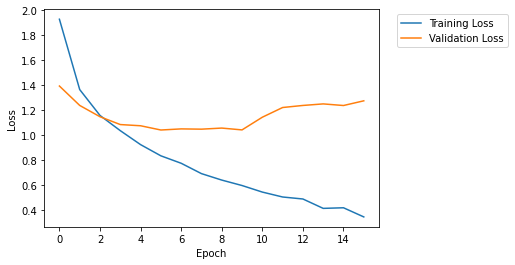

In [400]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the loss tensors collected in training mode
y = []
for step in trial.tensor("loss").steps(mode=ModeKeys.TRAIN):
    y.append(trial.tensor("loss").value(step, mode=ModeKeys.TRAIN)[0])
y = np.asarray(y)

# Retrieve the loss tensors collected in evaluation mode
y_val = []
for step in trial.tensor("loss").steps(mode=ModeKeys.EVAL):
    y_val.append(trial.tensor("loss").value(step, mode=ModeKeys.EVAL)[0])
y_val = np.asarray(y_val)

train_save_points = int(
    trial.tensor("scalar/train_steps_per_epoch").value(0)[0] / train_save_interval
)
val_save_points = int(trial.tensor("scalar/valid_steps_per_epoch").value(0)[0] / eval_save_interval)

y_mean = []
x_epoch = []
for e in range(int(trial.tensor("scalar/epoch").value(0)[0])):
    ei = e * train_save_points
    ef = (e + 1) * train_save_points - 1
    y_mean.append(np.mean(y[ei:ef]))
    x_epoch.append(e)

y_val_mean = []
for e in range(int(trial.tensor("scalar/epoch").value(0)[0])):
    ei = e * val_save_points
    ef = (e + 1) * val_save_points - 1
    y_val_mean.append(np.mean(y_val[ei:ef]))

plt.plot(x_epoch, y_mean, label="Training Loss")
plt.plot(x_epoch, y_val_mean, label="Validation Loss")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Check the rule job summary

The following cell returns the Debugger rule job summary. In this example notebook, we used the five built-in rules: `VanishingGradient`, `Overfit`, `Overtraining`, `SaturationActivation`, and `WeightUpdateRatio`. For more information about what each of the rules evaluate on the on-going training job, see the [List of Debugger built-in rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html) documentation in the Amazon SageMaker developer guide. Define the following `rule_status` object to retrieve Debugger rule job summaries.

In [ ]:
rule_status = estimator.latest_training_job.rule_job_summary()

In the following cells, you can print the Debugger rule job summaries and the latest logs. The outputs are in the following format:

```
{'RuleConfigurationName': 'Overfit',
 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:111122223333:processing-job/sagemaker-debugger-mnist-b-overfit-e841d0bf',
 'RuleEvaluationStatus': 'IssuesFound',
 'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule Overfit at step 7200 resulted in the condition being met\n',
 'LastModifiedTime': datetime.datetime(2020, 8, 27, 18, 17, 4, 789000, tzinfo=tzlocal())}
```

The `Overfit` rule job summary above is an actual output example of the training job in this notebook. It changes `RuleEvaluationStatus` to the `IssuesFound` status when it reaches the global step 7200 (in the 6th epoch). The `Overfit` rule algorithm determines if the training job is having Overfit issue based on its criteria. The default criteria to invoke the overfitting issue is to have at least 10 percent deviation between the training loss and validation loss.

Another issue that the training job has is the `WeightUpdateRatio` issue at the global step 500 in the first epoch, as shown in the following log.

```
{'RuleConfigurationName': 'WeightUpdateRatio',
 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:111122223333:processing-job/sagemaker-debugger-mnist-b-weightupdateratio-e9c353fe',
 'RuleEvaluationStatus': 'IssuesFound',
 'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule WeightUpdateRatio at step 500 resulted in the condition being met\n',
 'LastModifiedTime': datetime.datetime(2020, 8, 27, 18, 17, 4, 789000, tzinfo=tzlocal())}
```

This rule monitors the weight update ratio between two consecutive global steps and determines if it is too small (less than 0.00000001) or too large (above 10). In other words, this rule can identify if the weight parameters are updated abnormally during the forward and backward pass in each step, not being able to start converging and improving the model.

In combination of the two issues, it is clear that the model is not well setup to improve from the early stage of training. 

Run the following cells to track the rule job summaries.


**`VanishingGradient` rule job summary**

In [ ]:
rule_status[0]

**`Overfit` rule job summary**

In [ ]:
rule_status[1]

**`Overtraining` rule job summary**

In [ ]:
rule_status[2]

**`SaturationActivation` rule job summary**

In [ ]:
rule_status[3]

**`WeightUpdateRatio` rule job summary**

In [ ]:
rule_status[4]

## Notebook Summary and Other Applications

This notebook presented how you can have insights into training jobs by using SageMaker Debugger for any of your model running in a customized training container. The AWS cloud infrastructure, the SageMaker ecosystem, and the SageMaker Debugger tools make debugging process more convenient and transparent. The Debugger rule's `RuleEvaluationStatus` invocation system can be further extended to the Amazon CloudWatch Events and AWS Lambda function to take automatic actions, such as stopping training jobs once issues are detected. A sample notebook to set the combination of Debugger, CloudWatch, and Lambda is provided at [Amazon SageMaker Debugger - Reacting to CloudWatch Events from Rules](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-debugger/tensorflow_action_on_rule/tf-mnist-stop-training-job.ipynb).